# MSA 2024 Phase 2 - Part 2

The following is the continuation of my part one. In this section, I will use the clean data that I obtained to design a model to get intuition about weekly sales.

## 1. Load and split preprocessed data

In [20]:
import pandas as pd 

import seaborn as sns
import numpy as np

import math

import matplotlib.pyplot as plt


In [15]:
dataframe_file_path = './outputdataframes/processsalesdataframe.csv'
df_copy1 = pd.read_csv(dataframe_file_path, index_col=0)

### Prepare for model

We will eliminate the variables that do not have a correlation with weekly sales. We will also split our dependent variable from our independent variables.

In [16]:
X = df_copy1.drop(columns=["Weekly_Sales","Date","Temperature","Fuel_Price","CPI","Unemployment","Month"])

print(X)

y = df_copy1["Weekly_Sales"]

       Store  Dept  IsHoliday  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0          1     1          0   10382.90    6115.67     215.07    2406.62   
1          1     1          0    6074.12     254.39      51.98     427.39   
2          1     1          0    5629.51      68.00    1398.11    2084.64   
3          1     1          0    4640.65      19.00     105.02    3639.42   
4          1     1          0    5011.32      67.00     347.37     225.79   
...      ...   ...        ...        ...        ...        ...        ...   
90506     45    98          0   23641.30       6.00      92.93    6988.31   
90507     45    98          1   11024.45      12.80      52.63    1854.77   
90508     45    98          0    8452.20      92.28      63.24    2376.38   
90509     45    98          0    4556.61      20.64       1.50    1601.01   
90510     45    98          0    4018.91      58.08     100.00     211.94   

       MarkDown5  Type    Size  Week  Year  
0        6551.42     0  151315


We use standard scalar in order to standardize our features. 

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

## 2. Choose an algorithm
### Model choice 

In the following, we create a pipeline of models. In particular, we are going to use cross validation.  

KNN: 0.1998 ± 0.0215, [0.21150544 0.19947875 0.15426807 0.20283681 0.18278327 0.22788221
 0.17711146 0.17803556 0.24237105 0.18019236 0.20137915 0.21196815
 0.20486819 0.20687    0.21557517]
Decision Tree: 0.9387 ± 0.0098, [0.93847455 0.94177705 0.9181329  0.93996528 0.93662312 0.93719264
 0.95000787 0.94130065 0.93341401 0.93922996 0.91554697 0.9487309
 0.9440996  0.94999012 0.94593253]
Polynomial Regression (degree 3): 0.2100 ± 0.0116, [0.2160755  0.21553101 0.186591   0.209788   0.22046538 0.22261743
 0.20205641 0.19486636 0.20699321 0.19613377 0.20194148 0.23051816
 0.22061429 0.2106367  0.21506186]
Random Forest: 0.9669 ± 0.0034, [0.9658923  0.96182359 0.96389337 0.96699684 0.96542788 0.96207428
 0.96981687 0.97125772 0.96994065 0.96246286 0.96410218 0.97042637
 0.97194188 0.96984571 0.96746484]


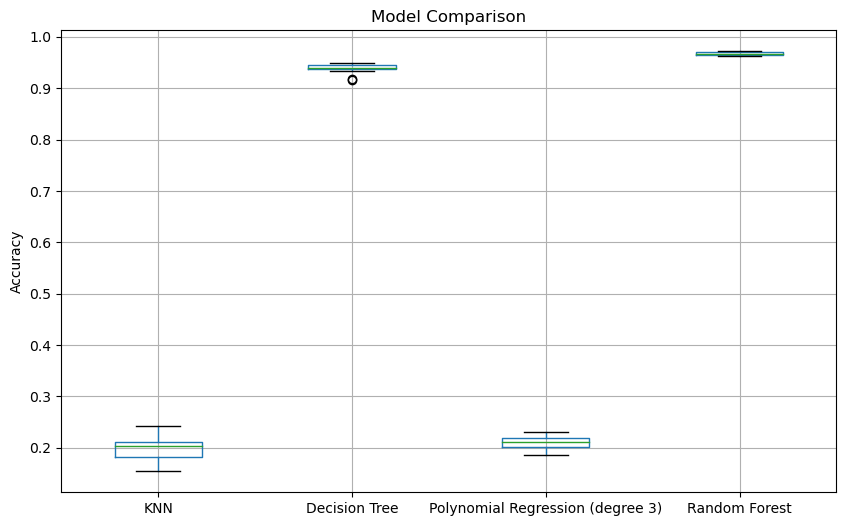

In [21]:
from sklearn.neighbors  import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, r2_score,mean_absolute_error
from sklearn.metrics import mean_squared_error




# Define models
models = {
    "KNN": KNeighborsRegressor(n_neighbors=3),
    "Decision Tree": DecisionTreeRegressor(),
    "Polynomial Regression (degree 3)": Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("linear_regression", LinearRegression())
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=100),
}


kf = KFold(n_splits=15, shuffle=True, random_state=42)


# Perform cross-validation for each model
results = {}



for name, model in models.items():
    cv_results = cross_val_score(model, X, y, cv=kf, scoring="r2")
    results[name] = cv_results
    print(f"{name}: {cv_results.mean():.4f} ± {cv_results.std():.4f}, {cv_results}")

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results)



# Box plot to compare model performances
plt.figure(figsize=(10, 6))
results_df.boxplot()
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.show()


In [22]:
results_df.head()

,KNN,Decision Tree,Polynomial Regression (degree 3),Random Forest
0,0.211505,0.938475,0.216075,0.965892
1,0.199479,0.941777,0.215531,0.961824
2,0.154268,0.918133,0.186591,0.963893
3,0.202837,0.939965,0.209788,0.966997
4,0.182783,0.936623,0.220465,0.965428


Random Forest gives us the best result. For cross validation, at each stratification, random forest has the highest r2 score. Due to this reason we will choose random forest as the desired model

## 3. Train and test the model

In [26]:
from sklearn.model_selection import train_test_split

X = df_copy1.drop(columns=["Weekly_Sales","Date","Temperature","Fuel_Price","CPI","Unemployment","Month"])

print(X)

y = df_copy1["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

RF = RandomForestRegressor(n_estimators=200)

RF.fit(X_train,y_train)



       Store  Dept  IsHoliday  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0          1     1          0   10382.90    6115.67     215.07    2406.62   
1          1     1          0    6074.12     254.39      51.98     427.39   
2          1     1          0    5629.51      68.00    1398.11    2084.64   
3          1     1          0    4640.65      19.00     105.02    3639.42   
4          1     1          0    5011.32      67.00     347.37     225.79   
...      ...   ...        ...        ...        ...        ...        ...   
90506     45    98          0   23641.30       6.00      92.93    6988.31   
90507     45    98          1   11024.45      12.80      52.63    1854.77   
90508     45    98          0    8452.20      92.28      63.24    2376.38   
90509     45    98          0    4556.61      20.64       1.50    1601.01   
90510     45    98          0    4018.91      58.08     100.00     211.94   

       MarkDown5  Type    Size  Week  Year  
0        6551.42     0  151315

RandomForestRegressor(n_estimators=200)

Plotting the predicted values vs the actual values.

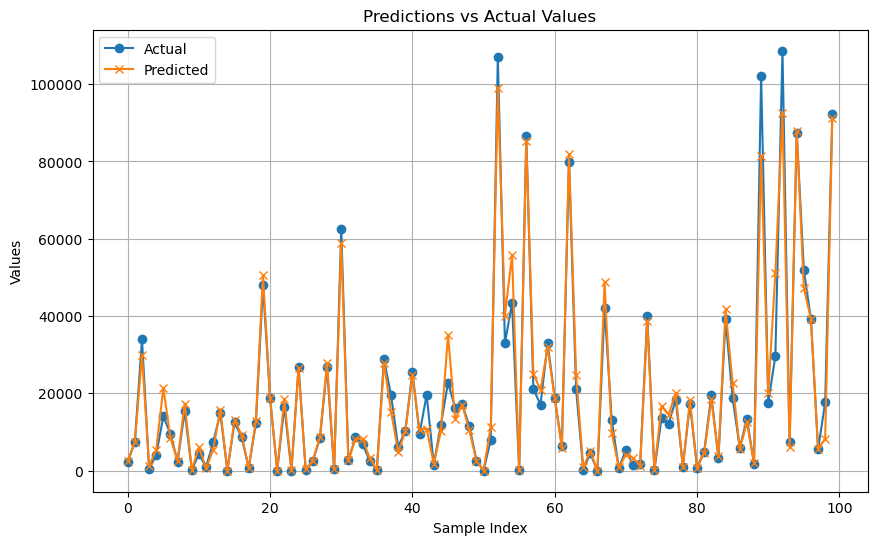

In [27]:
y_pred = RF.predict(X_test)


y_test_first_ten = y_test[0:100]
predictions_first_ten = y_pred[0:100]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(100), y_test_first_ten, marker='o', label='Actual')
plt.plot(range(100), predictions_first_ten, marker='x', label='Predicted')

# Adding titles and labels
plt.title('Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

 Let us evaluate some other metrics on it.

In [ ]:
#r2_score

r2_score(y_test,y_pred)

0.9604982270052176

In [ ]:
#mean_squared error

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(4745.051138910297)

In [ ]:
# Mean Absolute error

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)

mae

np.float64(2113.2363763517365)

In [ ]:
# calculate the symmetric mean absolute percentage error metric for trained model
def smape(y_true, y_pred):
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Calculate the numerator (absolute difference)
    numerator = np.abs(y_true - y_pred)
    # Calculate the denominator (average of absolute actual and predicted values)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Calculate SMAPE
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

print(smape(y_test,y_pred))

21.908183284401474


Our calculated metrics show that our model has good performance and a high r2-score of 0.96 indicating it will do well in making predictions.

## 5.Forecasting

We create a data frame, from the above data frame to make some predictions.

In [28]:
# Group features that are constant and average other columns
forcast_df=df_copy1.copy()
forcast_df=forcast_df.groupby(["Store","Dept","Week","Type", "Size"])[["Weekly_Sales","IsHoliday", "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5","Year"]].mean().reset_index(["Store","Dept","Week","Type", "Size"])
forcast_df=forcast_df.drop(columns=["Weekly_Sales"])
display(forcast_df.shape)
display(forcast_df.tail(10))

(90511, 12)

,Store,Dept,Week,Type,Size,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year
90501,45,98,38,1,118221,0.0,8452.20,92.28,63.24,2376.38,8670.40,2012.0
90502,45,98,39,1,118221,0.0,4556.61,20.64,1.50,1601.01,3288.25,2012.0
90503,45,98,43,1,118221,0.0,4018.91,58.08,100.00,211.94,858.33,2012.0
90504,45,98,45,1,118221,0.0,23052.25,5449.62,189.24,3355.69,3864.60,2011.0
90505,45,98,46,1,118221,0.0,4240.34,132.96,111.71,270.14,7073.00,2011.0
90506,45,98,48,1,118221,0.0,6835.61,120.76,802.79,2490.15,17861.50,2011.0
90507,45,98,49,1,118221,0.0,6176.69,2.87,379.57,1593.44,10170.50,2011.0
90508,45,98,50,1,118221,0.0,4631.26,8.92,801.34,848.33,2757.82,2011.0
90509,45,98,51,1,118221,0.0,797.10,89.14,1962.19,17.00,2985.51,2011.0
90510,45,98,52,1,118221,1.0,3604.35,43941.56,287.45,357.43,750.01,2011.0


Next replace year values to future, weeks 44-52 will be the end of 2012 and others will be in 2013

In [29]:
# Change year value to future
forcast_df.loc[forcast_df["Week"].isin(range(44)), "Year"] = 2013
forcast_df.loc[forcast_df["Week"].isin(range(43,53)), "Year"] = 2012
print(forcast_df.shape)
print(forcast_df[["Week","Year"]].tail(20))

(90511, 12)
       Week    Year
90491    27  2013.0
90492    28  2013.0
90493    29  2013.0
90494    30  2013.0
90495    31  2013.0
90496    32  2013.0
90497    33  2013.0
90498    34  2013.0
90499    35  2013.0
90500    36  2013.0
90501    38  2013.0
90502    39  2013.0
90503    43  2012.0
90504    45  2012.0
90505    46  2012.0
90506    48  2012.0
90507    49  2012.0
90508    50  2012.0
90509    51  2012.0
90510    52  2012.0


In [30]:
RF.feature_names_in_

array(['Store', 'Dept', 'IsHoliday', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'Type', 'Size', 'Week',
       'Year'], dtype=object)

In [31]:
alist = ["Store","Dept","IsHoliday", "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5","Type","Size","Week","Year"]

# Predict future sales
forcast_input = forcast_df[alist]
forcast_rf = RF.predict(forcast_input)

In [32]:
forcast_rf_df = pd.DataFrame(forcast_rf)
forcast_rf_df

,0
0,19719.09715
1,16257.52650
2,18470.66785
3,18666.18825
4,23578.72870
...,...
90506,618.99590
90507,551.49510
90508,761.59890
90509,965.37110


In [33]:
forcast_df["Weekly_Sales"]=forcast_rf

forcast_df

,Store,Dept,Week,Type,Size,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year,Weekly_Sales
0,1,1,1,0,151315,0.0,6277.39,21813.16,143.10,1450.13,8483.00,2013.0,19719.09715
1,1,1,2,0,151315,0.0,5183.29,8025.87,42.24,453.08,3719.38,2013.0,16257.52650
2,1,1,3,0,151315,0.0,4139.87,2807.19,33.88,500.62,3400.21,2013.0,18470.66785
3,1,1,4,0,151315,0.0,1164.46,1082.74,44.00,11.00,1222.19,2013.0,18666.18825
4,1,1,5,0,151315,0.0,34577.06,3579.21,160.53,32403.87,5630.40,2013.0,23578.72870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90506,45,98,48,1,118221,0.0,6835.61,120.76,802.79,2490.15,17861.50,2012.0,618.99590
90507,45,98,49,1,118221,0.0,6176.69,2.87,379.57,1593.44,10170.50,2012.0,551.49510
90508,45,98,50,1,118221,0.0,4631.26,8.92,801.34,848.33,2757.82,2012.0,761.59890
90509,45,98,51,1,118221,0.0,797.10,89.14,1962.19,17.00,2985.51,2012.0,965.37110


Plot of sales of Store 1 for future.

<Axes: title={'center': 'Future predictions'}, xlabel='Date', ylabel='Weekly Sales'>

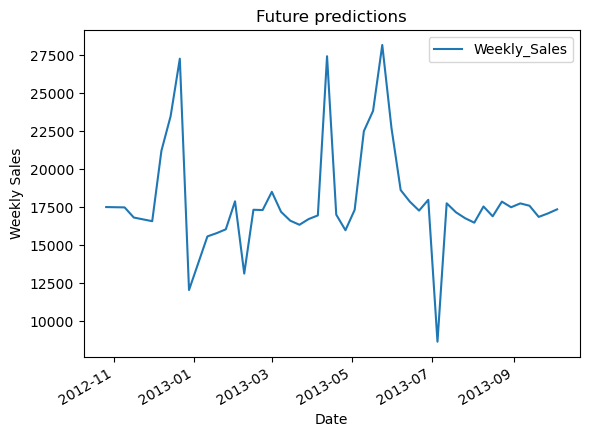

In [40]:

forcast_df_ave_WS = forcast_df.groupby(["Week","Year"])["Weekly_Sales"].mean().reset_index()

forcast_df_ave_WS["Year"]=forcast_df_ave_WS["Year"].astype(int)

forcast_df_ave_WS["Year_Week"] = pd.to_datetime(forcast_df_ave_WS["Year"].astype(str) + ' ' + forcast_df_ave_WS['Week'].astype(str) + ' 5',
                                format='%Y %U %w')

forcast_df_ave_WS.plot.line(x='Year_Week', y='Weekly_Sales', title='Future predictions', xlabel='Date', ylabel='Weekly Sales')

Our forcasting predicts one year into the future from the end of our given data in part 1. We do notice an increase in sales at the end of 2012 which is consistent with past year data around Holidays. However, there is a lot of fluctuation which could be due to the dropping of all null values in the markdown field. Dropping these field may have lead to a loss of information and an alternative approach would be for us to keep them in and replace them with zeroes or a mean accross weeks. Investigation into this would be the next step in improving our model and predictions it gives.

## Summary/Possible Modifications

There are a great variety of paths that one could take, to better or alternate the modeling that we have done above. For example, we could fill the NaN with the average. Or we could use different scalares to modify or standardize our inputs. Further investigation might lead to further eliminations of independent variables. 